## PARSEO 

In [1]:
import json
import os

def extract_texts_and_boxes_from_json(json_path):
    def find_texts_and_boxes(node):
        texts = []
        results = []
        count = 0
        if isinstance(node, dict):
            # Extrae el campo 'text' si existe y no está vacío
            if 'text' in node and isinstance(node['text'], str) and node['text'].strip().lower() not in ('', 'null', 'none'):
                 if 'bounds' in node and isinstance(node['bounds'], list) and len(node['bounds']) == 4:
                    x1, y1, x2, y2 = node['bounds']
                    results.append((x1, y1, x2, y2, str(node['text']).strip()))
               
            # Recursividad: busca en todos los valores que sean dict o list
            for value in node.values():
                if isinstance(value, (dict, list)):
                     results.extend(find_texts_and_boxes(value))
        elif isinstance(node, list):
            for item in node:
                results.extend(find_texts_and_boxes(item))
        return results

    # Carga el JSON
    with open(json_path, encoding='utf-8') as f:
        data = json.load(f)

    # Busca el nodo raíz correcto:
    root = None
    if 'activity' in data and 'root' in data['activity']:
        root = data['activity']['root']
    elif 'root' in data:
        root = data['root']
    else:
        root = data  # Recorre todo si no encuentra la estructura esperada

    results = find_texts_and_boxes(root)
    # Filtra vacíos y nulos
    #clean_texts = [t for t in texts if t and t.strip().lower() not in ('null', 'none')]
    return results



In [3]:
texto_extraido = extract_texts_and_boxes_from_json('D:/Dataset/combined/view_hierarchies/17.json')
print(texto_extraido)

[(148, 268, 1292, 387, 'User Licenses'), (99, 447, 1348, 2090, 'Copyright © 2005-2013, The Android Open Source Project \n\n Licensed under the Apache License, Version 2.0 (the License); you may not use this file except in compliance with the License. You may obtain a copy of the License at \n\n http://www.apache.org/licenses/LICENSE-2.0 \n\n Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an AS IS BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. \n\n Apache License \n Version 2.0, January 2004 \n http://www.apache.org/licenses/'), (92, 2092, 1348, 2260, 'OK')]


In [6]:
import csv
import re

DATA_DIR = 'D:/Downloads/unique_uis/combined_rico_test'   
OUTPUT_CSV = 'ocr_dataset_boxes.csv'

# Opcional: ignora imágenes con texto vacío
SKIP_EMPTY = True

# Caracteres a eliminar
REMOVE_CHARS = r"[\/\\,;\"`]"   # ajusta aquí lo que quieras eliminar

rows = []
for root, _, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith(('.png', '.jpg')):
            img_path = os.path.join(root, fname)
            img_path_fixed = img_path.replace('\\', '/')
            json_path = os.path.splitext(img_path)[0] + '.json'
            if not os.path.exists(json_path):
                continue
            for x1, y1, x2, y2, text in extract_texts_and_boxes_from_json(json_path):
                # Puedes limpiar texto si deseas aquí
                if not text.strip():
                    continue
                rows.append([img_path_fixed, x1, y1, x2, y2, text.strip()])

# Guardar CSV
with open(OUTPUT_CSV, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['image_path', 'x1', 'y1', 'x2', 'y2', 'text'])
    writer.writerows(rows)

print(f'Dataset OCR generado con {len(rows)} pares imagen/texto en "{OUTPUT_CSV}".')

Dataset OCR generado con 445 pares imagen/texto en "ocr_dataset_boxes.csv".


In [7]:
def load_ocr_pairs_from_json(data_dir):
    images, texts = [], []
    for root, _, files in os.walk(data_dir):
        for fname in files:
            if fname.lower().endswith('.png') or fname.lower().endswith('.jpg'):
                img_path = os.path.join(root, fname)
                json_path = os.path.splitext(img_path)[0] + ".json"
                if not os.path.exists(json_path):
                    continue
                text = extract_all_texts_from_json(json_path)
                if not text.strip():
                    continue  # O puedes poner algún string por defecto
                images.append(img_path)
                texts.append(text.lower())
    return images, texts


In [8]:
import pandas as pd
import re
# Carga el CSV
df = pd.read_csv('ocr_dataset_boxes.csv')

In [9]:
# Elimina filas donde el texto sea vacío, nulo o solo espacios

def clean_text(text):
    if not isinstance(text, str):
        return ''
    # Elimina todos los caracteres que NO estén en el rango unicode "latin basic" o símbolos comunes
    pattern = r'[^a-zA-Z0-9 .,:;!?@#%&()/\'"=_+\[\]{}<>|*$\-\\]'
    text = re.sub(pattern, '', text)
    return text

df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].astype(str).str.replace(r'[\r\n]+', ' ', regex=True)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df = df[df['text'].apply(lambda x: isinstance(x, str) and x.strip() != "")]
df = df[df['text'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]

In [10]:
# (Opcional) Reinicia el índice
df = df.reset_index(drop=True)

# Guarda el CSV limpio (puedes sobrescribir el original)
df.to_csv('ocr_dataset_boxes2.csv', index=False)

print(f"CSV limpio guardado. Total de ejemplos: {len(df)}")

CSV limpio guardado. Total de ejemplos: 445


In [11]:

# Por ejemplo, filtra textos de al menos 5 caracteres (después de strip)
longitud_minima = 2
df = df[df['text'].apply(lambda x: isinstance(x, str) and len(x.strip()) >= longitud_minima)]

# (Opcional) Reinicia el índice
df = df.reset_index(drop=True)

# Guarda el nuevo CSV filtrado
df.to_csv('ocr_dataset_boxes3.csv', index=False)

print(f"Filtrado por longitud >= {longitud_minima}. Total de ejemplos: {len(df)}")

Filtrado por longitud >= 2. Total de ejemplos: 443


# MODELO

### Configuración 

In [12]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split

print(tf.__version__)


2.19.0


In [13]:
# Configuración general
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 128
BATCH_SIZE = 16
MAX_LABEL_LEN = 24  # Máxima longitud de texto

In [14]:
ALPHABET = "abcdefghijklmnopqrstuvwxyz0123456789 .,:;!?@#%&()/\\'-_"
char_to_idx = {char: idx for idx, char in enumerate(ALPHABET)}  # 0 a N-1
idx_to_char = {idx: char for idx, char in enumerate(ALPHABET)}
num_classes = len(ALPHABET) + 1

def text_to_labels(text):
    return [char_to_idx.get(c, 0) for c in str(text).lower() if c in char_to_idx][:MAX_LABEL_LEN]

def labels_to_text(labels):
    return ''.join([idx_to_char.get(idx, '') for idx in labels if idx > 0])

class OCRBoxDataGenerator(Sequence):
    def __init__(self, csv_path, batch_size=16, image_height=32, image_width=128, max_label_len=24, char_to_idx=None):
        self.data = pd.read_csv(csv_path)
        self.batch_size = batch_size
        self.image_height = image_height
        self.image_width = image_width
        self.max_label_len = max_label_len
        self.char_to_idx = char_to_idx
        self.indices = np.arange(len(self.data))
        # Filtrar textos convertibles y regiones válidas
        self.data = self.data[self.data['text'].apply(self._is_valid_text)].reset_index(drop=True)

    def _is_valid_text(self, text):
        labels = self.text_to_labels(str(text))
        return 0 < len(labels) <= self.max_label_len

    def text_to_labels(self, text):
        labels = [self.char_to_idx[c] for c in str(text) if c in self.char_to_idx]
        return labels[:self.max_label_len]

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.data))
        batch = self.data.iloc[start:end]
        actual_batch_size = len(batch)
        X = np.zeros((actual_batch_size, self.image_height, self.image_width, 1), dtype=np.float32)
        Y = np.ones((actual_batch_size, self.max_label_len), dtype=np.int32) * 0
        input_length = np.ones((actual_batch_size, 1), dtype=np.int32) * (self.image_width // 4)
        label_length = np.zeros((actual_batch_size, 1), dtype=np.int32)
        j = 0  
        for _, row in batch.iterrows():
            img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Si la imagen tiene 3 canales, conviértela a grises
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            elif len(img.shape) == 2:
                pass  # ya es gris
            else:
                continue  # salta si la imagen tiene shape raro
                
            x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
            # Validar coordenadas
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(img.shape[1], x2)
            y2 = min(img.shape[0], y2)
            if x2 <= x1 or y2 <= y1:
                continue
            crop = img[y1:y2, x1:x2]
            crop = cv2.resize(crop, (self.image_width, self.image_height)).astype('float32') / 255.0
            #crop = np.expand_dims(crop, axis=-1)  # Para canal 1
            X[j, :, :, 0] = crop
            
            labels = self.text_to_labels(str(row['text']))
            labels = labels[:self.max_label_len]
            if len(labels) == 0:
                continue
            Y[j, :len(labels)] = labels
            label_length[j] = len(labels)
            j += 1

        X = X[:j]
        Y = Y[:j]
        input_length = input_length[:j]
        label_length = label_length[:j]
        return (X, Y, input_length, label_length), np.zeros(j)


### División de CSV

In [15]:
data = pd.read_csv('ocr_dataset_boxes3.csv')
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
train_data.to_csv('ocr_train_boxes.csv', index=False)
val_data.to_csv('ocr_val_boxes.csv', index=False)

train_gen = OCRBoxDataGenerator('ocr_train_boxes.csv', batch_size=16,
    image_height=32,
    image_width=128,
    max_label_len=24,
    char_to_idx=char_to_idx)
val_gen = OCRBoxDataGenerator('ocr_val_boxes.csv', batch_size=16,
    image_height=32,
    image_width=128,
    max_label_len=24,
    char_to_idx=char_to_idx)


### Modelo CRNN + CTC

In [16]:
def build_crnn(input_shape, num_classes):
    inp = layers.Input(shape=input_shape, name='image')
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)  # Opcional, mejora estabilidad
    x = layers.MaxPooling2D((2,1))(x)  # Reduce solo altura

    #new_shape = (IMAGE_WIDTH // 4, (IMAGE_HEIGHT // 4) * 64)
    new_shape = (input_shape[1] // 4, (input_shape[0] // 4) * 64)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # LSTM bidireccional + Dropout
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Dropout(0.4)(x)
    #out = layers.Dense(num_classes+1, activation='softmax')(x)  # +1 para el 'blank' de CTC
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=inp, outputs=out)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Modelo base (para inferencia)
#crnn_model = build_crnn((IMAGE_HEIGHT, IMAGE_WIDTH, 1), len(ALPHABET))
crnn_model = build_crnn((32, 128, 1), num_classes)

# Entradas para CTC
labels_in = layers.Input(name='labels', shape=[MAX_LABEL_LEN], dtype='int32')
input_length_in = layers.Input(name='input_length', shape=[1], dtype='int32')
label_length_in = layers.Input(name='label_length', shape=[1], dtype='int32')
ctc_loss = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [crnn_model.output, labels_in, input_length_in, label_length_in])

ctc_model = models.Model(
    inputs=[crnn_model.input, labels_in, input_length_in, label_length_in],
    outputs=ctc_loss
)

ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})
ctc_model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 32, 128,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 128,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 64,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 32, 64) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 32,     │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 32,     │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 512)   │    657,408 │ dense[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 512)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32, 55)    │     28,215 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, 24)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc (Lambda)        │ (None, 1)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ labels[0][0],     │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 830,391 (3.17 MB)

 Trainable params: 830,135 (3.17 MB)

 Non-trainable params: 256 (1.00 KB)

In [17]:
print("Input shape del modelo:", ctc_model.input_shape)

Input shape del modelo: [(None, 32, 128, 1), (None, 24), (None, 1), (None, 1)]


In [18]:
# ---- DEBUG SHAPES ----
print("== DEBUG SHAPES ==")
print("Modelo espera input_shape:", crnn_model.input_shape)

try:
    batch = train_gen[0][0][0]  # Primer batch de imágenes
    print("Shape del primer batch de imágenes (X):", batch.shape)
except Exception as e:
    print("Error obteniendo el batch del generador:", e)

# Opcional: verifica shape de un ejemplo individual
try:
    (X, Y, input_length, label_length), _ = train_gen[0]
    print("Shape de X:", X.shape)
    print("Shape de Y:", Y.shape)
    print("Shape de input_length:", input_length.shape)
    print("Shape de label_length:", label_length.shape)
except Exception as e:
    print("Error obteniendo shapes de batch completo:", e)
print("===================")


== DEBUG SHAPES ==
Modelo espera input_shape: (None, 32, 128, 1)
Shape del primer batch de imágenes (X): (6, 32, 128, 1)
Shape de X: (6, 32, 128, 1)
Shape de Y: (6, 24)
Shape de input_length: (6, 1)
Shape de label_length: (6, 1)


### Entrenamiento

In [25]:
EPOCHS = 20
from tensorflow.keras.callbacks import EarlyStopping

history = ctc_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)
crnn_model.save('ocr_crnn_model_boxes.h5')


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - loss: 40.5214 - val_loss: 45.1750
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 39.9738 - val_loss: 44.4643
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 40.1924 - val_loss: 43.2456
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 39.4141 - val_loss: 44.0082
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 38.1984 - val_loss: 42.7525
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 39.4390 - val_loss: 44.7752
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 39.2194 - val_loss: 43.9231
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 34.3625 - val_loss: 43.5602
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 40.0707 - val_loss: 43.9207
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 37.4945 - val_loss: 43.3644
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 36.7674 - val_loss: 44.7974
Epoch 12/20
24/24 ━━━━━━━━━━━━

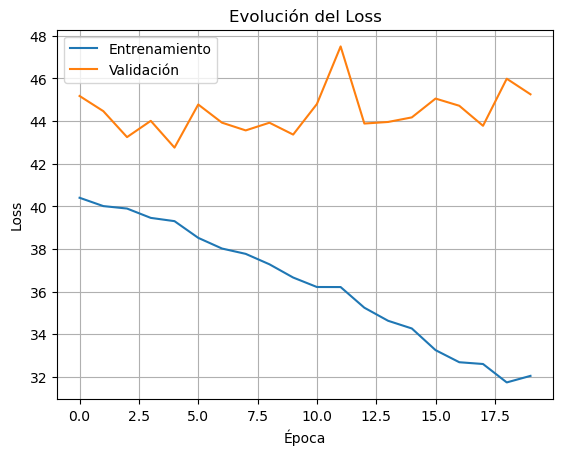

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución del Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from tensorflow.keras.models import load_model

def decode_batch(preds, alphabet=ALPHABET):
    out = tf.keras.backend.ctc_decode(preds, 
            input_length=np.ones(preds.shape[0])*preds.shape[1])[0][0].numpy()
    return [''.join([alphabet[c-1] for c in seq if c > 0 and c <= len(alphabet)]) for seq in out]

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

def predict_text(image_path, model_path='ocr_crnn_model_boxes.h5'):
    crnn_model = load_model(model_path)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT)).astype('float32') / 255.0
    img = np.expand_dims(img, axis=(0, -1))
    crnn_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})
    preds = crnn_model.predict(img)
    text = decode_batch(preds)[0]
    return text


model = load_model('ocr_crnn_model_boxes.h5')

In [24]:
predict_text('276.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


''